In [95]:
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import _zconfint_generic, _tconfint_generic
from scipy import stats
import scipy
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
df = pd.read_csv('credit_card_default_analysis.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

## Task 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
* a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
* b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [4]:
df_default0=df[df.default==0]['LIMIT_BAL']
df_default1=df[df.default==1]['LIMIT_BAL']

### 1.1. Проверим равенство средних по Критерию Стьюдента:

$H_0\colon$ средние значения кредитного лимита одинаково для тех, кто вернул кредит и тех, кто не вернул

$H_1\colon$ не одинаково.

Проверим, что распределения в выборках существенно не отличаются от нормальных. Проверяем визуально, поскольку 
Критерий Шапиро-Уилка не применим из-за большого объема выборки

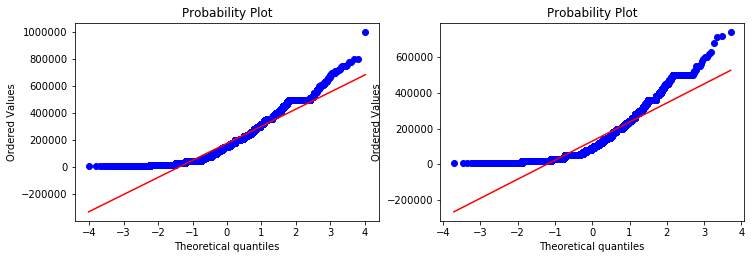

In [5]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(df_default0, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(df_default1, dist="norm", plot=pylab)
pylab.show()

Используем Двухвыборочный критерий Стьюдента (независимые выборки) 

In [6]:
stats.ttest_ind(df_default0, df_default1, equal_var = False)

Ttest_indResult(statistic=28.951587933509845, pvalue=3.3641002455114717e-178)

Получается, что нулевая гипотиза отвергается - возврат кредита зависит от кредитного лимита

In [154]:
### Перестановочный критерий

In [44]:
stats.mannwhitneyu(df_default0, df_default1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.1277429091116516e-190)

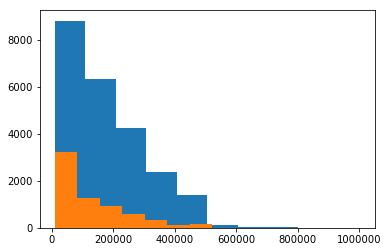

In [51]:
plt.hist(df_default0)
plt.hist(df_default1)
plt.show()

In [58]:
df_default0.sort_values(axis=0)

26928      10000
25178      10000
25181      10000
8443       10000
29379      10000
2212       10000
15919      10000
21018      10000
8490       10000
14506      10000
8498       10000
29393      10000
4653       10000
8504       10000
10648      10000
2242       10000
8548       10000
20949      10000
2253       10000
14514      10000
16988      10000
25220      10000
12580      10000
16950      10000
29416      10000
25200      10000
4510       10000
2196       10000
8416       10000
2038       10000
          ...   
1231      680000
23096     690000
23440     700000
7312      700000
811       700000
27459     700000
8448      700000
21320     700000
14300     700000
20784     700000
4033      710000
5878      710000
23091     710000
21122     710000
3689      710000
10647     720000
26112     720000
24686     730000
27557     730000
25126     740000
13186     750000
10089     750000
4603      750000
3733      750000
21375     760000
28715     780000
24320     780000
14919     8000

# Task 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

### Резюме
1. Данные в выборках бинарные
+ Из графиков видно, что женщин в выборках всегда больше, но как это влияет на возврат кредита не понятно 
+ Построим доверительный интервал на разность двух долей
+ Получили CI = [0.033635, 0.060548]
+ Доверительный интервал не содержит 0, похоже пол влияет на возврат кредита
+ Проверим Z критерий для двух долей (несвязанные выборки)
    * Нулевая гипотеза - распределение пола одинаковое в двух выборках
+ Получили p-value = 4.47287e-12
+ Гипотеза $H_0$ отвергается на ур. значимости 0.05

Вывод: Пол **влияет** на возврат кредита
    

In [92]:
# Формируем выборки по полу
df_default0=df[df.default==0]['SEX']
df_default1=df[df.default==1]['SEX']
# Бинаризируем значения
# 0 - мужской
# 1 - женский
df_default0=df_default0-1
df_default1=df_default1-1

### Построим гистограмы распределения признака в двух выборках

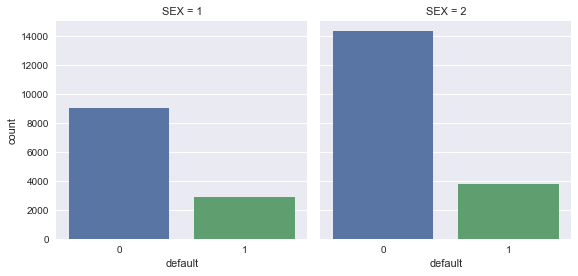

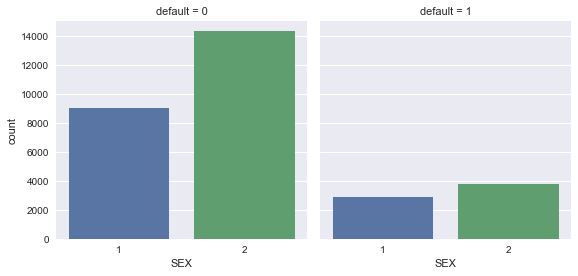

In [120]:
sns.factorplot(x="default",col="SEX", data=df,kind="count")
sns.factorplot(x="SEX",col="default", data=df,kind="count")
plt.show()

### Доверительный интервал для разности долей (независимые выборки)

In [36]:
# Расчет доверительного интервала для разности двух долей
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.) 
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    return (left_boundary, right_boundary)
print ("confidence interval: [%f, %f]" % proportions_diff_confint_ind(df_default0, df_default1))

### Z критерий для двух долей
Поскольку данные бинарные, то применим Z критерий для двух долей (выборки не связанные)

Гипотеза $H_0$ проверяет $p_0$=$p_1$, где $p_i$ - вероятность появления единицы в выборке.
Т.е. $H_0$  - гипотеза, что в 2х выборках (вернули/ не вернули кредит) распределение пола одинаковое. Другими словали, если $H_0$ верна, то пол не влияет на возврат кредита


In [66]:
# Z статистика
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))
# p-value
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized should be 'two-sided', 'less' or 'greater'")
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)
    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [67]:
z_stat = proportions_diff_z_stat_ind(df_default0, df_default1)
p_value=proportions_diff_z_test(z_stat,"two-sided")
print ("z-stat: %g, p-value: %g" % (z_stat,p_value))

z-stat: 6.92138, p-value: 4.47287e-12


# Task 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).

In [136]:
# Формируем выборки по образованию
df_default0=df[df.default==0]['EDUCATION']
df_default1=df[df.default==1]['EDUCATION']

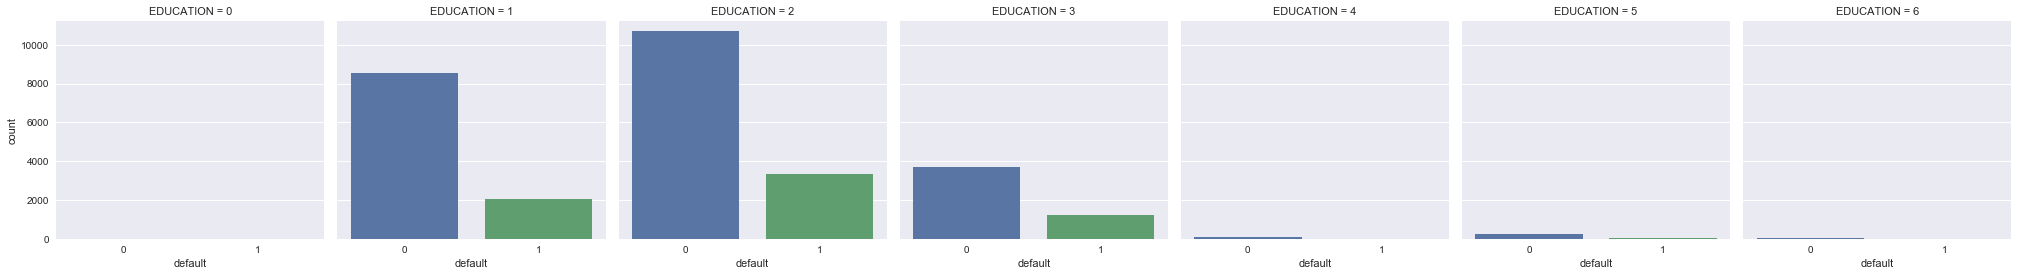

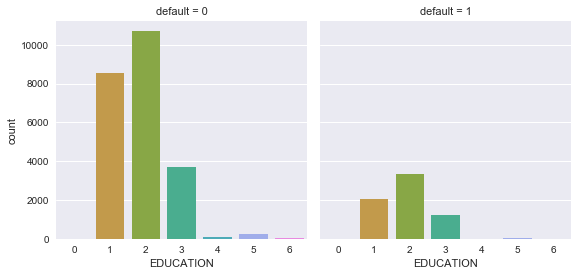

In [140]:
sns.factorplot(x="default",col="EDUCATION", data=df,kind="count")
sns.factorplot(x="EDUCATION",col="default", data=df,kind="count")
plt.show()

In [153]:
#len(df_default0)
# Вычилсяем ожидаемые значения
expected0=len(df_default0)/df_default0.value_counts().count()
expected1=len(df_default1)/df_default1.value_counts().count()
print (expected0,expected1)
print (df_default0.value_counts())
df_default0.value_counts()-expected0

3337.71428571 1106.0
2    10700
1     8549
3     3680
5      262
4      116
6       43
0       14
Name: EDUCATION, dtype: int64


2    7362.285714
1    5211.285714
3     342.285714
5   -3075.714286
4   -3221.714286
6   -3294.714286
0   -3323.714286
Name: EDUCATION, dtype: float64

In [135]:
pd.pivot_table(df, values='ID', index=['default'],columns=['EDUCATION'], aggfunc=len)

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14.0,8549.0,10700.0,3680.0,116.0,262.0,43.0
1,NaN,2036.0,3330.0,1237.0,7.0,18.0,8.0


In [128]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
5,6,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
6,7,500000,1,1,2,29,0,0,0,0,...,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
7,8,100000,2,2,2,23,0,0,0,0,...,221,-159,567,380,601,0,581,1687,1542,0
8,9,140000,2,3,1,28,0,0,2,0,...,12211,11793,3719,3329,0,432,1000,1000,1000,0
9,10,20000,1,3,2,35,0,0,0,0,...,0,13007,13912,0,0,0,13007,1122,0,0


# Task 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

# Task 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [124]:
df_default0=df[df.default==0]['AGE']
df_default1=df[df.default==1]['AGE']

In [125]:
df_default0

2        34
3        37
4        57
5        37
6        29
7        23
8        28
9        35
10       34
11       51
12       41
14       29
15       23
17       49
18       49
19       29
20       39
24       23
25       23
27       30
28       47
29       26
30       27
32       32
33       54
34       58
35       30
36       40
37       22
39       31
         ..
29960    29
29961    33
29962    30
29963    31
29964    31
29965    32
29967    32
29968    34
29969    33
29970    34
29971    36
29972    37
29975    41
29977    34
29978    39
29979    32
29980    42
29981    44
29983    44
29984    38
29985    30
29986    35
29987    34
29988    34
29989    35
29990    41
29992    43
29993    38
29995    39
29996    43
Name: AGE, dtype: int64

In [ ]:
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(df_default0, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(df_default1, dist="norm", plot=pylab)
pylab.show()